# Modeling and Simulation in Python

Project 3

James Ho & Richard Gao

In [328]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

## Asteroid Data 

https://cneos.jpl.nasa.gov/sentry/details.html#?des=410777

## Assumptions

Asteroid is moving linearly toward the earth.
Rocket has enough ionic fuel to keep from crashing into the asteroid indefinitely.
Spaceship is able to constantly apply a 5.4N force on the asteroid.
Assume that the tractor is applying an average force in one direction. We are abstracting the 3D motion to 2D.


## Implementation

In [329]:
# Here are the units we'll need

s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter

<Unit('meter')>

In [330]:
init = State(x = 145e9 * m,
             y = 5000 * m, # initially 0 because assumption that asteroid is in line with earth
             vx = -15.87e3 * m / s,
             vy = 0 * m / s)

,values
x,145000000000.0 meter
y,5000 meter
vx,-15870.0 meter / second
vy,0.0 meter / second


In [331]:
G = 6.674e-11 * N / kg**2 * m**2
mass_asteroid = 3.2e9 * kg
mass_spaceship = 6.91e3 * kg
force_spaceship=500 * N
r = (G * mass_asteroid * mass_spaceship / force_spaceship) ** .5

system = System(init=init,
                G=G,
                mass_earth=5.972e24 * kg,
                mass_asteroid=mass_asteroid,
                mass_spaceship=mass_spaceship,
                force_spaceship=force_spaceship,
                r=r,
                t_0=0 * s,
                t_end=0.5 * UNITS.year)

,values
init,x 145000000000.0 meter y ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
mass_earth,5.972e+24 kilogram
mass_asteroid,3200000000.0 kilogram
mass_spaceship,6910.0 kilogram
force_spaceship,500 newton
r,1.7179958556411015 meter
t_0,0 second
t_end,0.5 year


In [332]:
# Here's a function that computes the force of gravity

def universal_gravitation(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    x, y, vx, vy = state
    unpack(system)
    
    displacement = Vector(x, y)
    
    force = G * mass_earth * mass_asteroid / displacement.mag**2
    
    return displacement.hat() * force 

In [333]:
universal_gravitation(init, system)

<Quantity([6.06624540e+01 2.09180876e-06], 'newton')>

In [334]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    x, y, vx, vy = state
    unpack(system)    
    
    force = -universal_gravitation(state, system)
    
    dvxdt = force.x / mass_asteroid
#     dvydt = force.y / mass_asteroid
    
    try:
        if x.magnitude <= 0:
            dvydt = force.y / mass_asteroid
#             print('passed')
        else:
            dvydt = (force.y - force_spaceship) / mass_asteroid
    except:
        if x <= 0:
            dvydt = force.y / mass_asteroid
#             print('passed')
        else:
            dvydt = (force.y - force_spaceship) / mass_asteroid

#     print('x, y:',x, y)    
#     print('dvxdt, dvydt:',dvxdt, dvydt)
    
    return vx, vy, dvxdt, dvydt

In [335]:
slope_func(init, 0, system)

(<Quantity(-15870.0, 'meter / second')>,
 <Quantity(0.0, 'meter / second')>,
 <Quantity(-1.895701688466108e-08, 'newton / kilogram')>,
 <Quantity(-1.5625000065369025e-07, 'newton / kilogram')>)

In [336]:
results, details = run_ode_solver(system, slope_func, max_step=20*UNITS.day)
# details.tail()

In [337]:
# Scaling the time steps to days
results.index /= 60 * 60 * 24

# Scaling the distance to million km
x = results.x / 1e9;
y = results.y / 1e9;

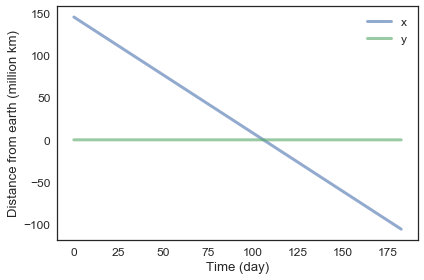

In [338]:
plot(x, label='x')
plot(y, label='y')

decorate(xlabel='Time (day)',
         ylabel='Distance from earth (million km)')

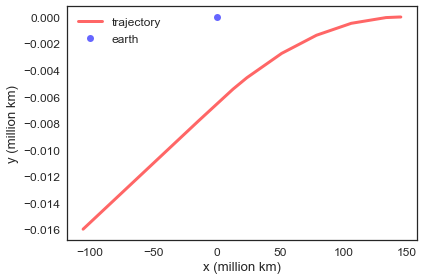

In [339]:
plot(x, y, 'r', label='trajectory')
plot(0, 0, 'ob', label='earth')

decorate(xlabel='x (million km)',
         ylabel='y (million km)')